In [20]:
import os, sys
sys.path.append('../')
os.environ["PYOPENGL_PLATFORM"] = "egl"

import numpy as np
import json
import math

import torch

import open3d as o3d
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [22]:
def plot_3d_point_cloud(x,
                        y,
                        z,
                        show=True,
                        show_axis=True,
                        in_u_sphere=False,
                        marker='.',
                        s=8,
                        alpha=.8,
                        figsize=(5, 5),
                        elev=10,
                        azim=240,
                        axis=None,
                        title=None,
                        lim=None,
                        *args,
                        **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if lim:
        ax.set_xlim3d(*lim[0])
        ax.set_ylim3d(*lim[1])
        ax.set_zlim3d(*lim[2])
    elif in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        lim = (min(np.min(x), np.min(y),
                   np.min(z)), max(np.max(x), np.max(y), np.max(z)))
        ax.set_xlim(1.3 * lim[0], 1.3 * lim[1])
        ax.set_ylim(1.3 * lim[0], 1.3 * lim[1])
        ax.set_zlim(1.3 * lim[0], 1.3 * lim[1])
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if show:
        plt.show()

    return fig

In [23]:
def read_depth(depth_path):
    depth_img = np.array(Image.open(depth_path))
    depth_img = depth_img.astype(np.float32) * 0.001
    
    
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(np.empty_like(depth_img)),
        o3d.geometry.Image(depth_img),
        depth_scale=1.0,
        depth_trunc=0.7,
        convert_rgb_to_intensity=False,
    )
    return rgbd

def sum_downsample_points(point_list, voxel_size=0.01, nb_neighbors=20, std_ratio=2.0):
    points = np.concatenate([np.asarray(x.points) for x in point_list], axis=0)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    return pcd

In [24]:
def normalize(tensor: torch.Tensor, dim: int) -> torch.Tensor:
    return tensor / ((tensor ** 2).sum(dim, keepdim=True).sqrt() + 1.0e-5)

def vector_to_rotation(vector):
    z = np.array(vector)
    z = z / np.linalg.norm(z)
    x = np.array([1, 0, 0])
    x = x - z*(x.dot(z)/z.dot(z))
    x = x / np.linalg.norm(x)
    y = np.cross(z, x)
    return np.c_[x, y, z]

def add_r_joint_to_scene(scene,
                             axis,
                             pivot_point,
                             length,
                             radius=0.01,
                             joint_color=[200, 0, 0, 180],
                             recenter=False):
    if recenter:
        pivot_point = np.cross(axis, np.cross(pivot_point, axis))
    rotation_mat = vector_to_rotation(axis)
    screw_tran = np.eye(4)
    screw_tran[:3, :3] = rotation_mat
    screw_tran[:3, 3] = pivot_point
    
    axis_cylinder = trimesh.creation.cylinder(radius, height=length)
    axis_arrow = trimesh.creation.cone(radius * 2, radius * 4)
    arrow_trans = np.eye(4)
    arrow_trans[2, 3] = length / 2
    axis_arrow.apply_transform(arrow_trans)
    axis_obj = trimesh.Scene((axis_cylinder, axis_arrow))
    screw = as_mesh(axis_obj)
    
    # screw.apply_translation([0, 0, 0.1])
    screw.apply_transform(screw_tran)
    screw.visual.face_colors = np.array(joint_color, dtype=np.uint8)
    scene.add_geometry(screw)
    return screw

# load data

In [25]:
# read data
root = '../data/real_laptop'
num_point_per_depth = 2048

with open(os.path.join(root, 'camera2base.json')) as f:
    transform_dict = json.load(f)

src_img_dir = os.path.join(root, 'imgs_1')
dst_img_dir = os.path.join(root, 'imgs_2')

transforms = transform_dict['camera2base']
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=640,
    height=480,
    fx=635.647,
    fy=635.647,
    cx=321.300,
    cy=241.436,
)
# read data
src_data = []
for idx in range(len(transforms)):
    rgbd = read_depth(os.path.join(src_img_dir, f'{idx}_depth.png'))
    src_data.append((rgbd, np.array(transforms[idx])))

dst_data = []
for idx in range(len(transforms)):
    rgbd = read_depth(os.path.join(dst_img_dir, f'{idx}_depth.png'))
    dst_data.append((rgbd, np.array(transforms[idx])))

In [26]:
# crop out the object
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(0.3, -0.5, 0.03), max_bound=(0.7, 0.16, 1))

# find bounding box of data
src_pc_list = []
for rgbd, trans in src_data:
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    # pcd, tmp = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.01)
    pcd.transform(trans)
    pcd = pcd.crop(bbox)
    pc = np.asarray(pcd.points)
    pc_idx = np.random.randint(0, pc.shape[0], size=(2048, ))
    pc = pc[pc_idx]
    src_pc_list.append(pc)
src_fused_pc = np.concatenate(src_pc_list, axis=0)
center = (np.min(src_fused_pc, 0) + np.max(src_fused_pc, 0)) / 2
scale = (np.max(src_fused_pc, 0) - np.min(src_fused_pc, 0)).max()
scale *= 1.1

# back project and normalize point cloud

src_pcd_list = []
for rgbd, trans in src_data:
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    pcd.transform(trans)
    pcd = pcd.crop(bbox)
    center_transform = np.eye(4)
    center_transform[:3, 3] = -center
    pcd.transform(center_transform)
    pcd.scale(1 / scale, np.zeros((3, 1)))
    src_pcd_list.append(pcd)
    
dst_pcd_list = []
for rgbd, trans in dst_data:
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    # pcd, tmp = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.01)
    pcd.transform(trans)
    pcd = pcd.crop(bbox)
    center_transform = np.eye(4)
    center_transform[:3, 3] = -center
    pcd.transform(center_transform)
    pcd.scale(1 / scale, np.zeros((3, 1)))
    dst_pcd_list.append(pcd)
    
src_pcd = sum_downsample_points(src_pcd_list, 0.02, 50, 0.1)
dst_pcd = sum_downsample_points(dst_pcd_list, 0.02, 50, 0.1)

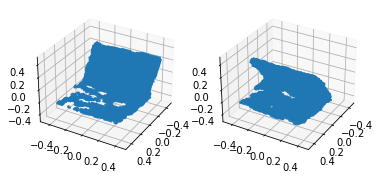

In [28]:
# visualize crop results
# tune crop box to get better isolated objects
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_3d_point_cloud(*np.asarray(src_pcd.points).T,
                    axis=ax,
                    azim=30,
                    elev=30,
                    lim=[(-0.5, 0.5)] * 3, show=False)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_point_cloud(*np.asarray(dst_pcd.points).T,
                    axis=ax,
                    azim=30,
                    elev=30,
                    lim=[(-0.5, 0.5)] * 3)

plt.show()

# Run model

In [29]:
import torch
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import hydra

from src.third_party.ConvONets.conv_onet.generation_two_stage import Generator3D
from src.utils.misc import sample_point_cloud

In [30]:
with initialize(config_path='../configs/'):
    config = compose(
        config_name='config',
        overrides=[
            'experiment=Ditto_s2m.yaml',
        ], return_hydra_config=True)
config.datamodule.opt.train.data_dir = '../data/'
config.datamodule.opt.val.data_dir = '../data/'
config.datamodule.opt.test.data_dir = '../data/'

/localhome/hja40/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/localhome/hja40/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [31]:
model = hydra.utils.instantiate(config.model)
ckpt = torch.load('../data/Ditto_s2m.ckpt')
device = torch.device(0)
model.load_state_dict(ckpt['state_dict'], strict=True)
model = model.eval().to(device)

In [32]:
generator = Generator3D(
    model.model,
    device=device,
    threshold=0.4,
    seg_threshold=0.5,
    input_type='pointcloud',
    refinement_step=0,
    padding=0.1,
    resolution0=32
)

In [33]:
pc_start = np.asarray(src_pcd.points)
pc_end = np.asarray(dst_pcd.points)

bound_max = np.maximum(pc_start.max(0), pc_end.max(0))
bound_min = np.minimum(pc_start.min(0), pc_end.min(0))
norm_center = (bound_max + bound_min) / 2
norm_scale = (bound_max - bound_min).max() * 1.1
pc_start = (pc_start - norm_center) / norm_scale
pc_end = (pc_end - norm_center) / norm_scale

pc_start, _ = sample_point_cloud(pc_start, 8192)
pc_end, _ = sample_point_cloud(pc_end, 8192)
sample = {
    'pc_start': torch.from_numpy(pc_start).unsqueeze(0).to(device).float(),
    'pc_end': torch.from_numpy(pc_end).unsqueeze(0).to(device).float()
}

In [34]:
mesh_dict, mobile_points_all, c, stats_dict = generator.generate_mesh(sample)
with torch.no_grad():
    joint_type_logits, joint_param_revolute, joint_param_prismatic = model.model.decode_joints(mobile_points_all, c)

# Visualize results

In [35]:
import trimesh
from src.utils.joint_estimation import aggregate_dense_prediction_r

from utils3d.mesh.utils import as_mesh
from utils3d.render.pyrender import get_pose, PyRenderer

INFO - 2022-07-11 21:48:54,604 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [36]:
renderer = PyRenderer(light_kwargs={'color': np.array([1., 1., 1.]), 'intensity': 9})

In [37]:
# compute articulation model
mesh_dict[1].visual.face_colors = np.array([84, 220, 83, 255], dtype=np.uint8)
joint_type_prob = joint_type_logits.sigmoid().mean()

if joint_type_prob.item()< 0.5:
    # axis voting
    joint_r_axis = (
        normalize(joint_param_revolute[:, :, :3], -1)[0].cpu().numpy()
    )
    joint_r_t = joint_param_revolute[:, :, 3][0].cpu().numpy()
    joint_r_p2l_vec = (
        normalize(joint_param_revolute[:, :, 4:7], -1)[0].cpu().numpy()
    )
    joint_r_p2l_dist = joint_param_revolute[:, :, 7][0].cpu().numpy()
    p_seg = mobile_points_all[0].cpu().numpy()

    pivot_point = p_seg + joint_r_p2l_vec * joint_r_p2l_dist[:, np.newaxis]
    (
        joint_axis_pred,
        pivot_point_pred,
        config_pred,
    ) = aggregate_dense_prediction_r(
        joint_r_axis, pivot_point, joint_r_t, method="mean"
    )
# prismatic
else:
    # axis voting
    joint_p_axis = (
        normalize(joint_param_prismatic[:, :, :3], -1)[0].cpu().numpy()
    )
    joint_axis_pred = joint_p_axis.mean(0)
    joint_p_t = joint_param_prismatic[:, :, 3][0].cpu().numpy()
    config_pred = joint_p_t.mean()
    
    pivot_point_pred = mesh_dict[1].bounds.mean(0)

In [38]:
scene = trimesh.Scene()
static_part = mesh_dict[0].copy()
mobile_part = mesh_dict[1].copy()
scene.add_geometry(static_part)
scene.add_geometry(mobile_part)
add_r_joint_to_scene(scene, joint_axis_pred, pivot_point_pred, 1.0, recenter=True)

<trimesh.Trimesh(vertices.shape=(100, 3), faces.shape=(192, 3))>

In [39]:
# render result mesh
camera_pose = get_pose(1.5, ax=np.pi / 3, ay=0, az=np.pi/2)
light_pose = get_pose(1.5, ax=np.pi / 3, ay=0, az=np.pi/2)
rgb, depth = renderer.render_mesh(scene, camera_pose, light_pose)

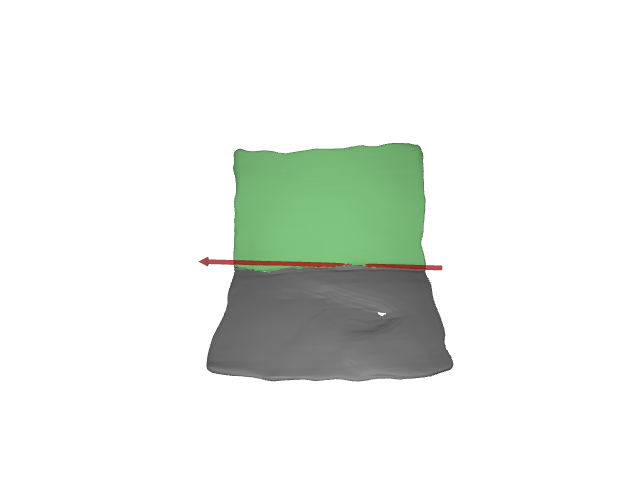

In [19]:
Image.fromarray(rgb)

In [ ]:
from open3d import JVisualizer
def visualize_pairs(pcd1, pcd2, pcd3=None):
    visualizer = JVisualizer()
    coordinate = o3d.geometry.TriangleMesh.create_coordinate_frame()
    pcd1.paint_uniform_color([1, 0, 0])
    pcd2.paint_uniform_color([0, 0, 1])
    if pcd3 == None:
        visualizer.add_geometry(pcd1)
        visualizer.add_geometry(pcd2)
        visualizer.add_geometry(coordinate)
    else:
        pcd3.paint_uniform_color([0.5, 0.5, 0.5])
        visualizer.add_geometry(pcd1)
        visualizer.add_geometry(pcd2)
        visualizer.add_geometry(pcd3)
        visualizer.add_geometry(coordinate)
    visualizer.show()

In [41]:
def get_arrow(origin=[0, 0, 0], end=None, color=[0, 0, 0]):
    """
    Creates an arrow from an origin point to an end point,
    or create an arrow from a vector vec starting from origin.
    Args:
        - end (): End point. [x,y,z]
        - vec (): Vector. [i,j,k]
    """
    vec_Arr = np.array(end) - np.array(origin)
    vec_len = np.linalg.norm(vec_Arr)
    mesh_arrow = o3d.geometry.TriangleMesh.create_arrow(
        cone_height=0.2 * vec_len,
        cone_radius=0.06,
        cylinder_height=0.8 * vec_len,
        cylinder_radius=0.04,
    )
    mesh_arrow.paint_uniform_color(color)
    rot_mat = caculate_align_mat(vec_Arr)
    mesh_arrow.rotate(rot_mat, center=np.array([0, 0, 0]))
    mesh_arrow.translate(np.array(origin))
    return mesh_arrow


def get_cross_prod_mat(pVec_Arr):
    # pVec_Arr shape (3)
    qCross_prod_mat = np.array([
        [0, -pVec_Arr[2], pVec_Arr[1]],
        [pVec_Arr[2], 0, -pVec_Arr[0]],
        [-pVec_Arr[1], pVec_Arr[0], 0],
    ])
    return qCross_prod_mat


def caculate_align_mat(pVec_Arr):
    scale = np.linalg.norm(pVec_Arr)
    pVec_Arr = pVec_Arr / scale
    # must ensure pVec_Arr is also a unit vec.
    z_unit_Arr = np.array([0, 0, 1])
    z_mat = get_cross_prod_mat(z_unit_Arr)

    z_c_vec = np.matmul(z_mat, pVec_Arr)
    z_c_vec_mat = get_cross_prod_mat(z_c_vec)
    if np.dot(z_unit_Arr, pVec_Arr) == -1:
        qTrans_Mat = -np.eye(3, 3)
    elif np.dot(z_unit_Arr, pVec_Arr) == 1:   
        qTrans_Mat = np.eye(3, 3)
    else:
        qTrans_Mat = np.eye(3, 3) + z_c_vec_mat + np.matmul(z_c_vec_mat,
                                                        z_c_vec_mat)/(1 + np.dot(z_unit_Arr, pVec_Arr))
    qTrans_Mat *= scale
    return qTrans_Mat

In [ ]:
static_part = mesh_dict[0].as_open3d
moving_part = mesh_dict[1].as_open3d

motion_state = config_pred
motion_axis = joint_axis_pred
# motion_origin = pivot_point_pred
motion_origin = np.cross(motion_axis, np.cross(pivot_point_pred, motion_axis))

motion_arrow = get_arrow(motion_origin, motion_axis+motion_origin)
visualize_pairs(static_part, moving_part, motion_arrow)


AttributeError: 'JVisualizer' object has no attribute 'add_geometrie'

: 